In [ ]:
from __future__ import absolute_import, division, print_function, unicode_literals

import os

import numpy as np

import matplotlib.pyplot as plt

import tensorflow as tf

keras = tf.keras

import scipy
import imageio
from skimage.transform import resize
from glob import glob
import numpy as np

from sklearn.model_selection import train_test_split

import cv2
from google.colab.patches import cv2_imshow


In [ ]:
%%bash

FILE=horse2zebra
rm -rf ./datasets
mkdir ./datasets

URL=https://people.eecs.berkeley.edu/~taesung_park/CycleGAN/datasets/$FILE.zip
ZIP_FILE=./datasets/$FILE.zip
TARGET_DIR=./datasets/$FILE/
wget -N $URL -O $ZIP_FILE
mkdir $TARGET_DIR
unzip $ZIP_FILE -d ./datasets/
rm $ZIP_FILE

mkdir -p ./images/$FILE/

Archive:  ./datasets/horse2zebra.zip
   creating: ./datasets/horse2zebra/trainA/
  inflating: ./datasets/horse2zebra/trainA/n02381460_6223.jpg  
  inflating: ./datasets/horse2zebra/trainA/n02381460_1567.jpg  
  inflating: ./datasets/horse2zebra/trainA/n02381460_3354.jpg  
  inflating: ./datasets/horse2zebra/trainA/n02381460_299.jpg  
  inflating: ./datasets/horse2zebra/trainA/n02381460_3001.jpg  
  inflating: ./datasets/horse2zebra/trainA/n02381460_4242.jpg  
  inflating: ./datasets/horse2zebra/trainA/n02381460_1666.jpg  
  inflating: ./datasets/horse2zebra/trainA/n02381460_4396.jpg  
  inflating: ./datasets/horse2zebra/trainA/n02381460_4502.jpg  
  inflating: ./datasets/horse2zebra/trainA/n02381460_8527.jpg  
  inflating: ./datasets/horse2zebra/trainA/n02381460_14.jpg  
  inflating: ./datasets/horse2zebra/trainA/n02381460_706.jpg  
  inflating: ./datasets/horse2zebra/trainA/n02381460_4019.jpg  
  inflating: ./datasets/horse2zebra/trainA/n02381460_1478.jpg  
  inflating: ./datasets/hor

for details.

--2021-02-25 11:34:35--  https://people.eecs.berkeley.edu/~taesung_park/CycleGAN/datasets/horse2zebra.zip
Resolving people.eecs.berkeley.edu (people.eecs.berkeley.edu)... 128.32.244.190
Connecting to people.eecs.berkeley.edu (people.eecs.berkeley.edu)|128.32.244.190|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 116867962 (111M) [application/zip]
Saving to: ‘./datasets/horse2zebra.zip’

     0K .......... .......... .......... .......... ..........  0% 1.19M 93s
    50K .......... .......... .......... .......... ..........  0% 2.49M 69s
   100K .......... .......... .......... .......... ..........  0% 80.4M 46s
   150K .......... .......... .......... .......... ..........  0% 2.55M 46s
   200K .......... .......... .......... .......... ..........  0% 67.1M 37s
   250K .......... .......... .......... .......... ..........  0%  160M 31s
   300K .......... .......... .......... .......... ..........  0%  167M 27s
   350K .......... .......... 

In [ ]:
def load_data( is_testing=False):
  data_type = "train" if not is_testing else "val"
  path_A = glob('./datasets/%s/%sA/*' % ('horse2zebra', data_type))
  path_B = glob('./datasets/%s/%sB/*' % ('horse2zebra', data_type))


  imgs_A = []
  imgs_B =[]
  label_A=[]
  label_B=[]
  for i in range(len(path_A)):
    img_A=cv2.imread(path_A[i])
    imgs_A.append(img_A)
    label_A.append(np.ones(1))
  for i in range(len(path_B)):
    img_B=cv2.imread(path_B[i])
    imgs_B.append(img_B)
    label_B.append(np.zeros(1))

  return imgs_A,imgs_B,label_A,label_B

In [ ]:
imgs_A,imgs_B,label_A,label_B=load_data()

In [ ]:
x=imgs_A+imgs_B
y=label_A+label_B

In [ ]:
x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=0.2,random_state=13)

In [ ]:
from tensorflow.keras.utils import to_categorical
x_train = np.array(x_train)/255.0
x_test  = np.array(x_test)/255.0

y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

In [ ]:
IMG_SIZE  = 256
IMG_SHAPE = (IMG_SIZE, IMG_SIZE, 3)

base_model = tf.keras.applications.ResNet101(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')


171450368/171446536 [==============================] - 2s 0us/step


In [ ]:
base_model.trainable = False

In [ ]:
base_model.summary()

Model: "resnet101"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 262, 262, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 128, 128, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 128, 128, 64) 256         conv1_conv[0][0]                 
__________________________________________________________________________________________

In [ ]:
flatten_layer = tf.keras.layers.Flatten()
num_classes = 2
prediction_layer = tf.keras.layers.Dense(num_classes, activation = 'softmax')

In [ ]:
model = tf.keras.Sequential([
  base_model,
  flatten_layer,
  prediction_layer
])

In [ ]:
#모델을 컴파일 함 

model.compile(loss='binary_crossentropy', 
              optimizer='adam', 
              metrics=['accuracy', 'top_k_categorical_accuracy'])

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet101 (Functional)       (None, 8, 8, 2048)        42658176  
_________________________________________________________________
flatten (Flatten)            (None, 131072)            0         
_________________________________________________________________
dense (Dense)                (None, 2)                 262146    
Total params: 42,920,322
Trainable params: 262,146
Non-trainable params: 42,658,176
_________________________________________________________________


In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint
mc = ModelCheckpoint('/content/drive/MyDrive/Colab Notebooks/term_project/mobile_v2_transfer.h5', 
                     monitor='val_accuracy', 
                     mode='max', 
                     verbose=1, 
                     save_best_only=True)

In [ ]:
history = model.fit(x_train, y_train, 
                     batch_size = 32,
                     validation_split = 0.2,
                     epochs=40,
                     callbacks=[mc])

#callback에 mc 가 아니라 earlystopping 넣어도 됨
#epochs 늘리면 더 정확도 높아짐

Epoch 1/40
48/48 [==============================] - 24s 265ms/step - loss: 2.2984 - accuracy: 0.6357 - top_k_categorical_accuracy: 1.0000 - val_loss: 0.4120 - val_accuracy: 0.8646 - val_top_k_categorical_accuracy: 1.0000

Epoch 00001: val_accuracy improved from -inf to 0.86458, saving model to /content/drive/MyDrive/Colab Notebooks/term_project/mobile_v2_transfer.h5
Epoch 2/40
48/48 [==============================] - 11s 228ms/step - loss: 0.4155 - accuracy: 0.8272 - top_k_categorical_accuracy: 1.0000 - val_loss: 0.5573 - val_accuracy: 0.7135 - val_top_k_categorical_accuracy: 1.0000

Epoch 00002: val_accuracy did not improve from 0.86458
Epoch 3/40
48/48 [==============================] - 11s 228ms/step - loss: 0.3586 - accuracy: 0.8338 - top_k_categorical_accuracy: 1.0000 - val_loss: 0.5119 - val_accuracy: 0.7917 - val_top_k_categorical_accuracy: 1.0000

Epoch 00003: val_accuracy did not improve from 0.86458
Epoch 4/40
48/48 [==============================] - 11s 230ms/step - loss: 0.

In [ ]:
loss, acc, k_acc = model.evaluate(x_test,  y_test, verbose=2)

print('모델의 정확도 (top-1-error): {:5.2f}%'.format(100*acc))
print('모델의 정확도 (top-5-error): {:5.2f}%'.format(100*k_acc))

16/16 - 5s - loss: 0.4214 - accuracy: 0.8711 - top_k_categorical_accuracy: 1.0000
모델의 정확도 (top-1-error): 87.11%
모델의 정확도 (top-5-error): 100.00%


### Fine tuning

In [ ]:
base_model.trainable = True

In [ ]:
# 기본 모델에 몇 개의 층이 있는지 확인 합니다.
print("Number of layers in the base model: ", len(base_model.layers))

Number of layers in the base model:  345


In [ ]:
base_model.summary()

Model: "resnet101"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 262, 262, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 128, 128, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 128, 128, 64) 256         conv1_conv[0][0]                 
__________________________________________________________________________________________

In [ ]:
fine_tune_at = 100

# `fine_tune_at` 층 이전의 모든 층을 고정
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable =  False

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet101 (Functional)       (None, 8, 8, 2048)        42658176  
_________________________________________________________________
flatten (Flatten)            (None, 131072)            0         
_________________________________________________________________
dense (Dense)                (None, 2)                 262146    
Total params: 42,920,322
Trainable params: 38,733,314
Non-trainable params: 4,187,008
_________________________________________________________________


https://www.tensorflow.org/api_docs/python/tf/keras/optimizers/Adam

In [ ]:
model.compile(loss='binary_crossentropy', 
              optimizer=tf.keras.optimizers.Adam(learning_rate = 0.0001),  # default learning rate = 0.001
              metrics=['accuracy', 'top_k_categorical_accuracy'])

In [ ]:
initial_epochs = 40
fine_tune_epochs = 80
total_epochs =  initial_epochs + fine_tune_epochs
history_fine = model.fit(x_train, y_train, 
                     batch_size = 32,
                     validation_split = 0.2,
                     epochs=total_epochs,
                     initial_epoch =  history.epoch[-1],
                     callbacks=[mc])

Epoch 40/120
48/48 [==============================] - 34s 548ms/step - loss: 5.9775 - accuracy: 0.7120 - top_k_categorical_accuracy: 1.0000 - val_loss: 2.0964 - val_accuracy: 0.6172 - val_top_k_categorical_accuracy: 1.0000

Epoch 00040: val_accuracy did not improve from 0.90885
Epoch 41/120
48/48 [==============================] - 25s 519ms/step - loss: 1.0102 - accuracy: 0.8471 - top_k_categorical_accuracy: 1.0000 - val_loss: 2.3601 - val_accuracy: 0.6458 - val_top_k_categorical_accuracy: 1.0000

Epoch 00041: val_accuracy did not improve from 0.90885
Epoch 42/120
48/48 [==============================] - 25s 515ms/step - loss: 0.4587 - accuracy: 0.9054 - top_k_categorical_accuracy: 1.0000 - val_loss: 1.0410 - val_accuracy: 0.7656 - val_top_k_categorical_accuracy: 1.0000

Epoch 00042: val_accuracy did not improve from 0.90885
Epoch 43/120
48/48 [==============================] - 25s 517ms/step - loss: 0.1372 - accuracy: 0.9487 - top_k_categorical_accuracy: 1.0000 - val_loss: 0.4937 - va

In [ ]:
loss, acc, k_acc = model.evaluate(x_test,  y_test, verbose=2)

print('모델의 정확도 (top-1-error): {:5.2f}%'.format(100*acc))
print('모델의 정확도 (top-5-error): {:5.2f}%'.format(100*k_acc))

16/16 - 5s - loss: 0.3004 - accuracy: 0.9272 - top_k_categorical_accuracy: 1.0000
모델의 정확도 (top-1-error): 92.72%
모델의 정확도 (top-5-error): 100.00%


In [ ]:
acc = history.history['accuracy']
acc += history_fine.history['accuracy']
val_acc = history.history['val_accuracy']
val_acc += history_fine.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']

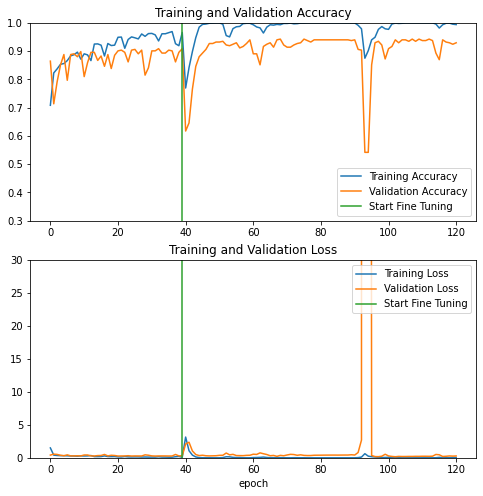

In [ ]:
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0.3, 1])
plt.plot([initial_epochs-1,initial_epochs-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, 30.0])
plt.plot([initial_epochs-1,initial_epochs-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()